In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_row', 100)
pd.set_option('display.max_info_columns', 100)


    - Datafield
    - DBNOs(Down But Not Out)   적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
    - assists                   아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
    - boosts                    부스트 아이템 사용 횟수
    - damageDealt               총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
    - headshotKills             헤드샷 킬 수
    - heals                     힐링 아이템 사용 횟수
    - Id                        플레이어 ID
    - killPlace                 매치에서의 킬수만 따졋을때 순위
    - killPoints                킬 수로 산정한 ELO의 개념. rankpoints가 없다면 killPoints가 존재 
    - killStreaks               짧은 시간동안 최대한 많이 킬했을 때의 킬 수 / 죽지않고 킬을 했을때 
    - kills                     총 킬 수
    - longestKill               킬과 킬 사이의 이동한 가장 긴 거리
    - matchDuration             매치의 시간 (초 단위)   -> 맵 사이즈에 따른 시간이 다르다 (평균 : 30분, 23분 )
    - matchId                   매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
    - matchType                 매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 
                                나머지는 이벤트 또는 커스텀 매치
    - rankPoints                랭킹 ELO의 개념
    - revives                   아군 부활 횟수
    - rideDistance              탈것으로 이동한 총 거리
    - roadKills                 탈것으로 킬한 횟수
    - swimDistance              수영한 총 거리
    - teamKills                 팀킬 횟수
    - vehicleDestroys           차량 폭파 횟수
    - walkDistance              걸어간 총 거리 total : 3 map 
                                -> map 2개 : 8 X 8 km => 최대 대각선 길이 : 11.3km
                                   map 1개 : 4 X 4 km => 최대 대각선 길이 : 5.6km
    - weaponsAcquired           얻은 무기의 수
    - winPoints                 승리 횟수로 판단한 ELO의 개념
    - groupId                   매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 
                                새로운 그룹 아이디가 부여됨
    - numGroups                 게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)
    - maxPlace                  한 경기내 최하 등수()
    - winPlacePerc              예측 목표, 1에 가까워질 수록 순위가 높아진다. 
                                (0부터 1까지의 값으로 나타냄. 1은 1등을, 0은 꼴등을 의미한다.)
                                (maxPlace-winPlace)/(maxPlace-1) = winPlacePerc
                                즉, 경기에 들어온 팀수에 따라 경기 등수가 결정된다.

## 사전 지식 전달 사항

- 기본 게임 진행 방식 : 

- 우승 조건 :

- 기타 : 

## 기본 사항

In [71]:
# 이벤트 메치 드랍된 자료 사용
data_path = 'C:/Users/hojun/Documents/dev/Kaggle-PUBG/'
df = pd.read_csv(data_path+'event_drop.csv')

In [72]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [73]:
df = df.drop(index=df[df.winPlacePerc.isna()].index) # index : 2738537  find NaN

In [74]:
df = reduce_mem_usage(df)
drop_proof_df = df.copy()

## 핵 사용 유저 선별 및 제거 함수 

In [75]:
def hack_user_drop(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    ### Anomalies in aim 1 (More than 50 kills) ###
    df.drop(df[df['kills'] >= 40].index, inplace=True)
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    df.drop(df[df['headshotKills'] >= 15].index, inplace=True)
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    df.drop(df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)].index , inplace=True)
    ### Anomalies in aim 3 (Longest kill) ###
    df.drop(df[df['longestKill'] >= 1000].index, inplace=True)
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    df.drop(df[df['DBNOs'] >= 20].index, inplace=True)
    ### Anomalies in movement ###
    # walkDistance anomalies
    df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
    # rideDistance anomalies
    df.drop(df[df['rideDistance'] >= 25000].index, inplace=True)
    # swimDistance anomalies
    df.drop(df[df['swimDistance'] >= 1500].index, inplace=True)
    ### Anomalies in item 1 (weaponsAcquired) ###
    df.drop(df[df['weaponsAcquired'] >= 50].index, inplace=True)
    ### Anomalies in item 2 (heals) ###
    df.drop(df[df['heals'] >= 40].index, inplace=True)
    ### Anomalies in item 3 (boosts) ###
    df.drop(df[df['boosts'] >= 15].index, inplace=True)
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    df.drop(df[df['killStreaks'] >= 10].index ,inplace=True)
    # revive zombies (revives >= 10)
    df.drop(df[df['revives'] >= 10].index ,inplace=True)
    #Weapon master (weaponsAcquired >= 50)
    df.drop(df[df['weaponsAcquired'] >= 50].index ,inplace=True)
    #team killer = troll ( teamkills > 4)
    df.drop(df[df['teamKills'] >= 50].index ,inplace=True)
    # Strange road killer (roadKills>= 5)
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    # Too little walkDistance
    df.drop(df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)].index, inplace=True)
    # superman ?
    df.drop(df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)].index, inplace=True)
    # Maybe cheater & Gosu
    df.drop(df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)].index, inplace=True)
    return df

In [76]:

def hack_users(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    ### Anomalies in aim 1 (More than 50 kills) ###
    hack_users = pd.concat([hack_users, df[df['kills'] >= 40]])
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    hack_users = pd.concat([hack_users, df[df['headshotKills'] >= 15]])
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    hack_users = pd.concat([hack_users, df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)]])
    ### Anomalies in aim 3 (Longest kill) ###
    hack_users = pd.concat([hack_users, df[df['longestKill'] >= 1000]])
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    hack_users = pd.concat([hack_users, df[df['DBNOs'] >= 20]])
    ### Anomalies in movement ###
    # walkDistance anomalies
    hack_users = pd.concat([hack_users, df[df['walkDistance'] >= 10000]])
    # rideDistance anomalies
    hack_users = pd.concat([hack_users, df[df['rideDistance'] >= 25000]])
    # swimDistance anomalies
    hack_users = pd.concat([hack_users, df[df['swimDistance'] >= 1500]])
    ### Anomalies in item 1 (weaponsAcquired) ###
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    ### Anomalies in item 2 (heals) ###
    hack_users = pd.concat([hack_users, df[df['heals'] >= 40]])
    ### Anomalies in item 3 (boosts) ###
    hack_users = pd.concat([hack_users, df[df['boosts'] >= 15]])
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    hack_users = pd.concat([hack_users, df[df['killStreaks'] >= 10]])
    # revive zombies (revives >= 10)
    hack_users = pd.concat([hack_users, df[df['revives'] >= 10]])
    #Weapon master (weaponsAcquired >= 50)
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    #team killer.append(troll ( teamkills > 4)
    hack_users = pd.concat([hack_users, df[df['teamKills'] >= 50]])
    # Strange road killer (roadKills>= 5)
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    # Too little walkDistance
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)]])
    # superman ?
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)]])
    # Maybe cheater & Gosu
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)]])
    return hack_users

## 핵 유저 관련 feature 생성

In [77]:
hack_user_drop(df)
df.drop(columns='headshot_rate', inplace=True)

- 핵사용 유저 확인 (핵 중복 사용 유저 정리 포함)

In [78]:
hack_user = hack_users(drop_proof_df)
drop_proof_df.drop(columns='headshot_rate', inplace=True)
hack_user.drop(columns='headshot_rate', inplace=True)
hack_user = hack_user.drop_duplicates('Id') # 핵 중복 사용 유저 정리

In [79]:
hack_fuature_add_df = drop_proof_df.copy()

- 핵유저 포함 팀 표시 feature 생성

In [80]:
hack_user_groupid = str(list(hack_user.groupId.values))

# -> 핵유저가 있는 팀 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_team"] = hack_fuature_add_df.groupId.apply(lambda x : 0 if hack_user_groupid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

- 핵유저 참여 경기 표시 feature 생성

In [81]:
hack_user_matchid = str(list(hack_user.matchId.values))

# -> 핵유저가 참여한 경기 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_game"] = hack_fuature_add_df.matchId.apply(lambda x : 0 if hack_user_matchid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

In [82]:
# 핵유저 제거 확인
# set(list(hack_user['groupId'])) & set(list(hack_team_drop[hack_team_drop['hack_user_team']==0]['groupId']))

In [120]:
# 핵 유저가 참여한 경기 수
hack_game_count = round(hack_fuature_add_df.groupby('matchId')['hack_user_game'].agg(np.mean).sum())

print('핵유저수 :', hack_user.index.size, '\t\t\t',  '전체 참가인원 :', drop_proof_df.index.size, '\t','비율 :', round((hack_user.index.size/drop_proof_df.index.size*100), 3))
print('핵유저 포함 팀수 :', len(set(list(hack_user['groupId']))), '\t\t', '전체 참가팀수 :', len(set(list(drop_proof_df['groupId']))), '\t', '비율 :',round( len(set(list(hack_user['groupId'])))/len(set(list(drop_proof_df['groupId'])))*100 ,3))
print('핵유저팀 포함된 인원수 :', hack_fuature_add_df['hack_user_team'].sum(), '\t', '전체 참가인원 :', drop_proof_df.index.size, '\t','비율 :', round((hack_fuature_add_df['hack_user_team'].sum()/drop_proof_df.index.size*100), 3))
print('핵유저팀 포함된 경기수 :',hack_game_count,'\t', '전체 경기수 :', drop_proof_df.matchId.nunique(), '\t\t','비율 :', round((hack_game_count/drop_proof_df.matchId.nunique()*100), 3))

핵유저수 : 3170 			 전체 참가인원 : 4437084 	 비율 : 0.071
핵유저 포함 팀수 : 2263 		 전체 참가팀수 : 2022539 	 비율 : 0.112
핵유저팀 포함된 인원수 : 7593 	 전체 참가인원 : 4437084 	 비율 : 0.171
핵유저팀 포함된 경기수 : 1566 	 전체 경기수 : 47848 		 비율 : 3.273


### 핵유저가 포함된 경기들에서 핵유저가 거둔 성적 정리

In [85]:
# 핵유저가 포함된 팀과 경기
hack_team_include_team = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 1]
hack_team_include_game = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 1]

- 핵유저 포함 팀 또는 개인의 성적 확인 (우승 빈도, 전체 평균 성적)


In [127]:
# 핵유저 개인 or 팀 우승 빈도
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
print('핵유저 우승 횟수:', hack_win_count ,'\t\t', '핵유저 참여 경기수:', hack_game_count, '\t', '우승 확률 :', round(hack_win_count/hack_game_count*100, 3))

# 핵유저 개인 or 팀 평균 등수
hack_team_no_include = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 0]
print('핵유저팀 평균 등수 :', round(hack_team_include_team.winPlacePerc.mean(), 3), '\t', '일반 유저팀 평균 등수', round(hack_team_no_include.winPlacePerc.values.mean(), 3))
print('핵유저 평균 등수 :', hack_user.winPlacePerc.values.mean(), '\t', '일반 평균 등수 :', round(hack_fuature_add_df.winPlacePerc.values.mean(), 3))


핵유저 우승 횟수: 1351 		 핵유저 참여 경기수: 1566 	 우승 확률 : 86.271
핵유저팀 평균 등수 : 0.688 	 일반 유저팀 평균 등수 0.472
핵유저 평균 등수 : 0.796 	 일반 평균 등수 : 0.473


In [ ]:
# 팀별 평균 예상 : 0.5  실제 값 : 0.4998  
# hack_fuature_add_df.groupby('groupId')['winPlacePerc'].agg(np.mean).values.mean()

- 핵유저의 우승 확률이 86% 가 넘는 수치가 나옴
- 핵유저를 포함한 팀은 성적 상승
- 핵유저는 평균 등수 상승 
- 핵유저가 참석한 경기 -> 공정한 경기로 보기 어려움

#### 결과 : 핵유저가 참석한 경기와 같은 팀들의 상황을 분석하고 해당 경기 제외


## 핵유저가 없는 공평한 경기가 이루어졌을때를 전제로 프로젝트를 수행하겠다

In [128]:
hack_fuature_add_df = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 0]

In [129]:
hack_fuature_add_df.index.size

4333378

## drop

### drop 핵유저 포함된 경기

### drop event game 

In [ ]:
# drop_event = ['crashfpp', 'flaretpp', 'flarefpp', 'crashtpp']
# for i in drop_event:
#     indexNames = df[df['matchType'].str.contains(i)].index
#     df.drop(indexNames,  inplace=True)


#### 이유

전체 데이터의 0.1%도 차지하지 않는 데이터양과 이상치, 특이한 방식의 게임 운영으로 이벤트 경기는 제외

### drop columns

#### 'killPoints', 'winPoints', 'rankPoints' drop

In [ ]:
drop_columns = ['killPoints', 'winPoints', 'rankPoints']
df.drop(columns=drop_columns, inplace=True)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,0,0,0.00,1306,squad-fpp,28,26,0,0.0000,0,0.000,0,0,244.80,1,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0.00,1777,squad-fpp,26,25,0,0.0045,0,11.040,0,0,1434.00,5,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0.00,1318,duo,50,47,0,0.0000,0,0.000,0,0,161.80,2,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0.00,1436,squad-fpp,31,30,0,0.0000,0,0.000,0,0,202.70,3,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,1,1,58.53,1424,solo-fpp,97,95,0,0.0000,0,0.000,0,0,49.75,2,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,0,0,0.00,1873,squad-fpp,29,28,0,1292.0000,0,0.000,0,0,1019.00,3,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0.00,1435,solo,93,93,0,0.0000,0,0.000,0,0,81.70,6,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0.00,1321,squad-fpp,28,28,0,0.0000,0,2.184,0,0,788.70,4,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,2,1,98.50,1373,squad-fpp,26,25,2,0.0000,0,0.000,0,0,2748.00,8,0.8000


##### 이유 

'killPoints', 'winPoints', 'rankPoints' 상관관계도로 확인

결과에 의한 수치들을 계산한 값으로써 너무 높은 영향(leakage)를 확인하여 제외

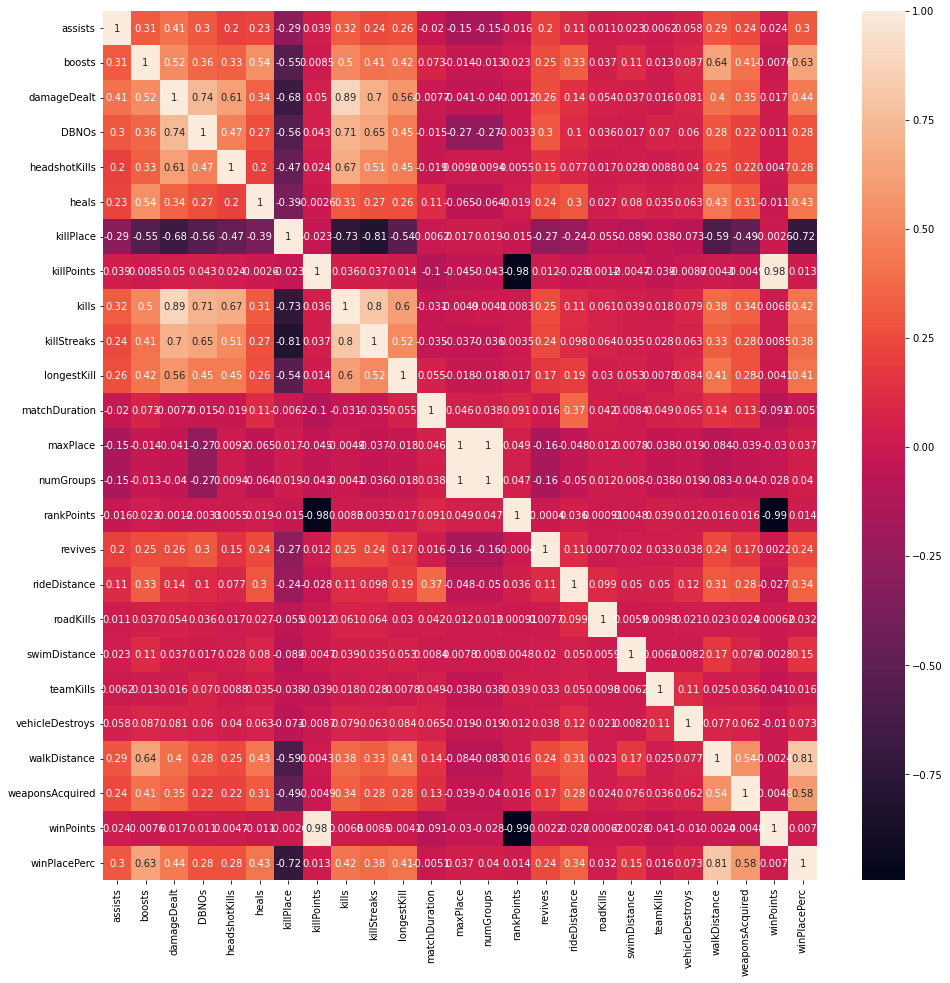

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(data=drop_proof_df.corr(), annot=True)
plt.show()

#### 'numGroups' drop

In [ ]:
df.drop(columns='numGroups', inplace=True)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,-1,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,1484,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,1491,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,1408,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,1560,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,1029,0,0,0.00,1873,squad-fpp,29,-1,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,0,0,0,0.00,1435,solo,93,1501,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,0,0,0,0.00,1321,squad-fpp,28,1500,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,0,2,1,98.50,1373,squad-fpp,26,1418,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


##### 이유

- 예측값 : 1 (1등)의 이동 거리 분포 확인

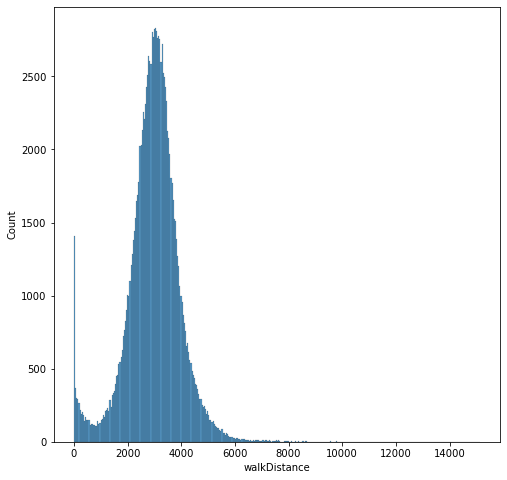

In [ ]:
wpp_1 =drop_proof_df[drop_proof_df['winPlacePerc'] == 1]['walkDistance']
plt.figure(figsize=(8, 8))
sns.histplot(data=drop_proof_df, x=wpp_1 )
plt.show()

- 1등인데 이동거리가 0인 data 확인

In [ ]:
drop_proof_df[(drop_proof_df['winPlacePerc'] == 1) & (drop_proof_df['walkDistance']==0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3702,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,1,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0
8790,106afdb574db25,4b0ae4659e9936,cf0cb51c829eb5,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,1,0,1.0
9264,0351565a7058e9,3663a93a319725,3659fe3694262a,0,0,0.3218,0,0,0,1,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
18426,e6d6f94558dd2f,22818b9a9a6159,486200c5613f14,0,1,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,19,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
19054,d0683f5d780f09,faebf5c484de4a,ec9a90395ed8c0,0,0,99.0000,0,0,0,1,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,9,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429697,6cc9d7b1643cbd,11fce60d5c8ea3,60c6e90b964266,3,0,645.6000,6,1,0,28,0,5,2,57.58,1216,normal-squad-fpp,6,6,1500,2,0.0,0,0.0,0,0,0.0,31,0,1.0
4430451,69f2d577afb916,1ca82eb3229fe3,8b1af8b54b0edb,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,18,2,1500,0,0.0,0,0.0,0,0,0.0,0,0,1.0
4432272,87a4d46be07ec6,7921c8beb38c2d,2183f03b8dd456,0,3,115.6000,0,0,1,2,0,0,0,0.00,1808,solo,20,2,1500,0,0.0,0,0.0,0,0,0.0,6,0,1.0
4443248,120b7d2d32663f,b70109a45eb127,6db87452a2db21,0,0,0.0000,0,0,0,2,0,0,0,0.00,1808,solo,17,2,1500,0,0.0,0,0.0,0,0,0.0,3,0,1.0


In [ ]:
drop_proof_df[drop_proof_df['matchId']=='01aead02bb8901']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
3692,3fc123559fc935,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,1,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,3,0,1.0
52397,0a2d95936da4ae,c70fd467685d53,01aead02bb8901,0,0,178.5000,0,0,0,16,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,3,0,0.0
152554,d205ebdd9c0034,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,4,0,0,0,0.0,1808,solo,20,2,1500,0,7304.0,0,4.851562,0,0,593.000000,5,0,1.0
230675,40b3cf3ded58ef,c70fd467685d53,01aead02bb8901,0,0,0.0000,0,0,0,11,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,3,0,0.0
312980,1e726bf8c7afbf,5cef1df7ee3551,01aead02bb8901,0,0,119.3750,0,0,0,3,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,8,0,1.0
449983,3e5d4dea709622,c70fd467685d53,01aead02bb8901,0,0,78.0000,0,0,0,10,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,3,0,0.0
762729,39c64d1652702e,c70fd467685d53,01aead02bb8901,0,0,0.0000,0,0,0,20,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,0,0,0.0
1319387,c5ae332274f01c,c70fd467685d53,01aead02bb8901,0,0,0.0000,0,0,0,18,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,7,0,0.0
1688326,618a59dc602a34,c70fd467685d53,01aead02bb8901,0,0,159.0000,0,0,0,9,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,5,0,0.0
1839645,00d5eab45b85f3,5cef1df7ee3551,01aead02bb8901,0,0,0.0000,0,0,0,2,0,0,0,0.0,1808,solo,20,2,1500,0,0.0,0,0.000000,0,0,0.000000,3,0,1.0


    - 수치상 불가능한 data (이동거리 없이 무기획득 등) 확인  되어 제외

- maxPlace(경기당 마지막 등수)와 numGroups(경기 참가팀수)가 다른 경기들 확인

In [ ]:
temp_df = drop_proof_df[drop_proof_df.maxPlace != drop_proof_df.numGroups].sort_values(by=['numGroups','matchId'])[['winPlacePerc', 'numGroups', 'maxPlace', 'matchId']]
temp_df

,winPlacePerc,numGroups,maxPlace,matchId
337842,0.000000,1,18,07baf6b1ba3de9
671026,0.000000,1,18,07baf6b1ba3de9
1056287,0.000000,1,18,07baf6b1ba3de9
1664753,0.000000,1,18,07baf6b1ba3de9
2046163,0.000000,1,18,07baf6b1ba3de9
...,...,...,...,...
4291031,0.545410,99,100,fe1be8e33af055
4295868,0.171753,99,100,fe1be8e33af055
4334803,0.373779,99,100,fe1be8e33af055
4370186,0.797852,99,100,fe1be8e33af055


- numGroups : 1 인 경우 예측값이 0으로 된다.

    -> numGroups : 1 인 경우 제외


In [ ]:
temp_df.head(18)

,winPlacePerc,numGroups,maxPlace,matchId
338573,0.0,1,18,07baf6b1ba3de9
672453,0.0,1,18,07baf6b1ba3de9
1058582,0.0,1,18,07baf6b1ba3de9
1668428,0.0,1,18,07baf6b1ba3de9
2050651,0.0,1,18,07baf6b1ba3de9
2225696,0.0,1,18,07baf6b1ba3de9
2278786,0.0,1,18,07baf6b1ba3de9
2323919,0.0,1,18,07baf6b1ba3de9
2400004,0.0,1,18,07baf6b1ba3de9
2499812,0.0,1,18,07baf6b1ba3de9


In [ ]:
temp_df[temp_df['numGroups']==1]['winPlacePerc'].unique()

array([0.])

numGroups과 maxPlace가 일치하지 않는 경우 확인

- maxPlace : 3 이하인 경우는 없었고

- maxPlace의 value와 winPlacePerc(예측값)의 분할갯수가 일치하였고 

    -> numGroups는 일치하지 않는 경우가 있어서 numGroups는 제외

In [ ]:
temp_df[temp_df['maxPlace'] <=3]

,winPlacePerc,numGroups,maxPlace,matchId


In [ ]:
temp_df[temp_df['numGroups']==5]['winPlacePerc'].unique()

array([0.8   , 0.6   , 0.2   , 1.    , 0.    , 0.4   , 0.625 , 0.25  ,
       0.5   , 0.7143, 0.4286, 0.1429, 0.8333, 0.3333])

In [ ]:
temp = []
for i in range(4, 101):
    temp.append([i, temp_df[temp_df['maxPlace']==i]['winPlacePerc'].nunique()])
print(temp)

[[4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 44], [54, 54], [55, 55], [56, 55], [57, 57], [58, 57], [59, 52], [60, 60], [61, 60], [62, 62], [63, 50], [64, 64], [65, 65], [66, 66], [67, 64], [68, 68], [69, 69], [70, 70], [71, 71], [72, 69], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99], [100, 100]]


### drop isna True

In [ ]:
# df[df['winPlacePerc'].isna()]   # -> index : 2744604
df.drop(index=2744604, inplace=True)

## data 분석을 위해 match type으로 data 분리

### feature를 추가하는것이 메모리 관리나 그런것이 더좋지 않을까?

In [ ]:
adsfagasg

- solo와 팀전으로 data 분리 csv로 저장

In [ ]:
# solo_df = df[df['matchType'].str.contains('solo')]
# duo_squad_df = df.drop(df[df['matchType'].str.contains('solo')].index)
# solo_df.to_csv('C:/Users/hojun/Documents/dev/Kaggle-PUBG/solo_df.csv')
# duo_squad_df.to_csv('C:/Users/hojun/Documents/dev/Kaggle-PUBG/duo_squad_df.csv')

In [ ]:
# duo_squad_df = pd.read_csv('C:/Users/hojun/Documents/dev/Kaggle-PUBG/duo_squad_df.csv')
# solo_df = pd.read_csv('C:/Users/hojun/Documents/dev/Kaggle-PUBG/solo_df.csv')

## 정규화 가능한 feature 정리

- 각 경기 100명 인원으로 가정하고 관련 column들 정규화
    - kills, damageDealt, maxPlace, matchDuration

In [ ]:
def normalization(df):
    df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
    df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
    df['maxPlaceNorm'] = df['maxPlace']*((100-df['playersJoined'])/100 + 1)
    df['matchDurationNorm'] = df['matchDuration']*((100-df['playersJoined'])/100 + 1)

    for i in ['kills', 'damageDealt', 'maxPlace', 'matchDuration']:
        df.drop(columns=i, inplace=True)

#### 데이터 분포에 50%이상이 0 인 feature들의 0인 플레이어들의 winPlacePerc 기준 수치

In [ ]:
# 함수로 생성
def zeropoint_corr_winPlacePerc(df):
    zero_point_list = ['assists', 'boosts','DBNOs', 'kills','damageDealt', 'headshotKills', 'heals', 'killStreaks', 'longestKill', 'revives', 'roadKills',  'swimDistance','rideDistance',  'teamKills', 'vehicleDestroys']
    
    print('column','\t\t\t', 'winPlacePerc 평균', '\t', 'count', '\t\t', '전체 대비 비율')
    for i in zero_point_list:
        if len(i) <=6:
            print(i,'\t\t\t', df[df[i] == 0]['winPlacePerc'].mean(),'\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100) )
        elif len(i) < 14:
            # print(i,'\t\t', '{:.3f}'.format(temp[temp[i] == 0]['winPlacePerc'].mean()),'\t', temp[temp[i] == 0]['winPlacePerc'].count())
            print(i,'\t\t', df[df[i] == 0]['winPlacePerc'].mean(),'\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        else:
            print(i,'\t', df[df[i] == 0]['winPlacePerc'].mean(),'\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
    print('참가수 \t\t\t\t\t\t', df.index.size)

# 팀별 EDA

#### team data에 팀별로 groupby 하여 팀원수 column 추가

In [ ]:
duo_squad_df['team_members'] = duo_squad_df.groupby('groupId').Id.transform('count')
team_df = duo_squad_df.groupby('groupId').agg(np.mean)

- duo, squad 게임에서 상관관계

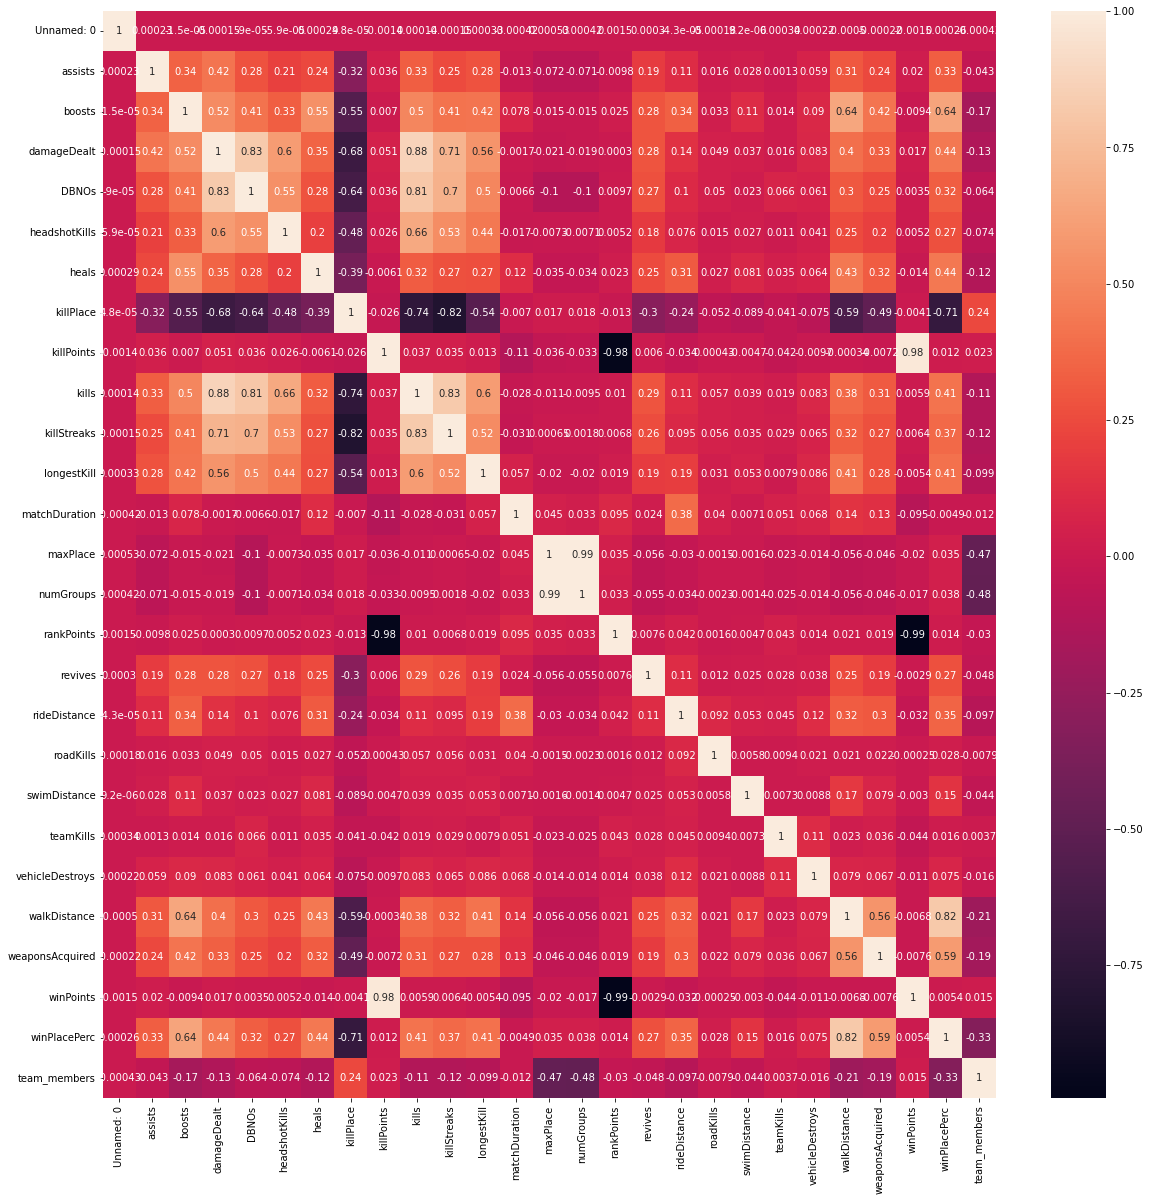

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data=duo_squad_df.corr(), annot=True)
plt.show()

'killPoints', 'winPoints', 'rankPoints' columns은 상관관계가 너무 높고 

에측값에 대한 독립 column이 아닌 결과로 나온 계산 값이므로 제외

- 팀별로 모았을때 예측값에 대한 상관관계

In [ ]:
team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']

winPlacePerc       1.000000
walkDistance       0.841553
boosts             0.715072
weaponsAcquired    0.679188
damageDealt        0.539011
kills              0.519190
longestKill        0.510483
heals              0.505212
killStreaks        0.484075
DBNOs              0.430078
assists            0.416625
revives            0.372075
headshotKills      0.363958
rideDistance       0.352008
swimDistance       0.165250
vehicleDestroys    0.104502
roadKills          0.039845
teamKills          0.022767
killPoints         0.012549
rankPoints         0.010762
winPoints          0.005952
matchDuration      0.004295
Unnamed: 0         0.000370
maxPlace          -0.002326
numGroups         -0.002536
team_members      -0.189547
killPlace         -0.808702
Name: winPlacePerc, dtype: float64

    - walkDistance 아주 높은 상관관계를 확인 할 수 있다
        - 경기에서 오래 살아 남을수록 자기장을 피해 안전 지역으로 이동해야 되므로 
            대체로 이동거리가 늘어난다.(낙하지점과 안전지역이 가까운 경우 제외)

- 팀별 column value : 0 인 데이터들 파악

In [ ]:
zeropoint_corr_winPlacePerc(team_df)

column 			 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.41945285302988095 	 832904 	 62.67676433228383
boosts 			 0.25177262846370585 	 493330 	 37.123519815063425
DBNOs 			 0.38414640948588513 	 337765 	 25.417115663622518
kills 			 0.35814908626899133 	 419270 	 31.550439164173355
damageDealt 		 0.32896560014159154 	 101701 	 7.653090403404953
headshotKills 		 0.42788439023468494 	 846752 	 63.718838607918805
heals 			 0.2815235396931446 	 502908 	 37.84427280553365
killStreaks 		 0.35814908626899133 	 419270 	 31.550439164173355
longestKill 		 0.35937267688735147 	 422020 	 31.75737910192582
revives 		 0.4245509835060015 	 888505 	 66.86078887009289
roadKills 		 0.4992243561399898 	 1320784 	 99.39016681616509
swimDistance 		 0.47361630774227825 	 1182236 	 88.96430699953646
rideDistance 		 0.40523051839637936 	 869682 	 65.4443414343421
teamKills 		 0.4990798251872994 	 1250138 	 94.07399269163392
vehicleDestroys 	 0.49516670333025903 	 1300109 	 97.83435473869882
참가수 						 13

- vehicleDestroys, roadKills, teamKills의 경우 최소 94%이 0 인 data이고 예측값 평균도 0.5에 가까운 값 
    
    -> 예측값에 골고루 분포되어있어 영향을 주기가 힘든 것으로 보인다.
- boosts, heals의 경우 아이템을 사용하지 않으면 하위 등수가 나오는것을 확인 할 수 있다.

    -> 두 column은 위의 상관관계에서도 높은 영향이 있었고 수치가 높을수록 높은 등수가 예상된다.

In [ ]:
drop_proof_df['team_members'] = drop_proof_df.groupby('groupId').Id.transform('count')
team_df = drop_proof_df.groupby('groupId').agg(np.mean)

- 차량파괴(vehicleDestroys)에 따른 등수 확인

In [ ]:
for i in range(7):
    print( i, team_df[team_df['vehicleDestroys'] == i]['winPlacePerc'].mean())

0 0.496005274487456
1 0.7434114914425427
2 0.7777563909774435
3 0.7559846153846154
4 0.8442666666666666
5 0.9149
6 nan


- 팀원수에 따른 등수 확인

In [ ]:
for i in range(1, 5):
    print('팀원수 :', i, '평균 승률:', round(team_df[(team_df['team_members']==i) &( team_df['winPlacePerc'])]['winPlacePerc'].mean(), 3))


팀원수 : 1 평균 승률: 0.507
팀원수 : 2 평균 승률: 0.525
팀원수 : 3 평균 승률: 0.532
팀원수 : 4 평균 승률: 0.562


    - 팀원이 늘어날수록 등수가 상승한다. ( 1명 대 4명 : 5%차이)

- 팀킬에 따른 등수 확인

In [ ]:
for i in range(0, 6):
    print('팀킬수 :', i, '평균 승률:', round(team_df[(team_df['teamKills']==i) &( team_df['winPlacePerc'])]['winPlacePerc'].mean(),3))

팀킬수 : 0 평균 승률: 0.511
팀킬수 : 1 평균 승률: 0.538
팀킬수 : 2 평균 승률: 0.512
팀킬수 : 3 평균 승률: 0.521
팀킬수 : 4 평균 승률: 0.426
팀킬수 : 5 평균 승률: nan


In [ ]:
for i in range(1, 5):
    print('팀킬수 :', i, '\t', '평균 팀원수 :', round(team_df[team_df['teamKills']==i]['team_members'].mean(),3),'\t', '팀수:',team_df[team_df['teamKills']==i].index.size)

팀킬수 : 1 	 평균 팀원수 : 1.296 	 팀수: 16477
팀킬수 : 2 	 평균 팀원수 : 1.026 	 팀수: 313
팀킬수 : 3 	 평균 팀원수 : 1.0 	 팀수: 43
팀킬수 : 4 	 평균 팀원수 : 1.143 	 팀수: 7


    - 팀킬 수에 따른 등수 확인 도중 팀원수보다 팀킬수가 더 높은 것을 확인
        -> 핵유저 삭제로 팀원 감소인지 확인 -> 여전히 팀킬수가 팀원수보다 많은 것을 확인 -> 드랍 결정

        insight : 핵유저 삭제시 팀원이 존재할 경우 같이 삭제해야 좋을 데이터를 만들수 있다.

### 경기내 팀 수에 따른 등수 예측 방법